# Project 3 - Sentiment Classification

### Grup 5 - AI 2

Anggota Kelompok: 
* Diah Ayu Setyaningsih
* I Nyoman Warsana
* Iman Santoso

## Upload File

In [3]:
from google.colab import files
files.upload()

Saving New Sentiment.zip to New Sentiment.zip


{'New Sentiment.zip': b'PK\x03\x04\n\x00\x00\x00\x00\x00\xc0z\x98N\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\x00\x1c\x00Sentiment/UT\t\x00\x03\x87\x00\xc0\\\x96\x00\xc0\\ux\x0b\x00\x01\x04\xe8\x03\x00\x00\x04\xe8\x03\x00\x00PK\x03\x04\x14\x00\x00\x00\x08\x00is\tKw\xdf{M\xaf\x08\x00\x00=\x1c\x00\x00 \x00\x1c\x00Sentiment/stopword_list_TALA.txtUT\t\x00\x036\x9d\x8aY6\x9d\x8aYux\x0b\x00\x01\x04\xe8\x03\x00\x00\x04\xe8\x03\x00\x00]Y\xcb\x8e\xeb:\x0e\xdc\x1f\xe0|J>\xe2.f7\xab\x99{\xd7\x03\xa5#$\x8al\xb7aIh\xf4\xdf\x0fYU\x94\xddg\x11VQ\xef\'I+\x7f\xfd\xfd\xbf\x7f\xfe\xfb\xaf\xff\xfc\xfe\xf5\xd7\xdf\xc4\x7f\xfe\xf3\xef\xdf\xbf\x8e\xfe\xfbWz$\x88%\xbd\x80\xdb7\xf5}l\x86\xcfT)\x99\xfcL\x87\xc9\x9a6\xca\x8a:\xf5U\x0eA\x11\xb2t\x1d\x10lyM\x9d\x92\xea\x86n\xb7\xe8w\xebh\xd9!\x05\xb2\x91\x9d\x02]\xee\xe9^\x16\xea\xecz\xb7\xea\xcf\x02\xd2\x91p\xf4\xc2j--\x94\x1clO\rrP\xb2\xb6\x11\xce\xf2\x0b\x85M\xa2\xee\xdd\xa6Y\x04\xa8\r\xb6\xa6-](Z\x98\x1a\x9a\xb9c(.Y\xe9\xa5\xca\xaf\xaf$hI\x1d\x94\xea\xb

## Import Library

In [0]:
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Extract dan Import File

In [0]:
archive = ZipFile('/content/New Sentiment.zip')
data_latih = pd.read_json(archive.open('Sentiment/data_latih.json'))
stop_word = archive.open('Sentiment/stopword_list_TALA.txt').readlines()
dict_df = pd.read_csv(archive.open('Sentiment/dictionary.csv'))
key_norm_df = pd.read_csv(archive.open('Sentiment/key_norm.csv'))

## Banyaknya Label Kelas

In [212]:
data_latih.sentimen.value_counts()

positif    291
negatif    181
netral     178
Name: sentimen, dtype: int64

## Data Preprocessing

In [213]:
data_latih.drop(['akun','id_user','tanggal'],axis=1,inplace=True)
data_latih.head()

,isi,sentimen
0,RT @AhokDjarot: Penasaran sama #BasukiDjarot? ...,netral
1,@AhokDjarot Melayani warga jakarta mulai dari ...,positif
2,@Lintank01 @AhokDjarot Golongan sumbu pendek l...,negatif
3,RT @RahyaMaya: https://t.co/pvVUIp3YYw Pak Aho...,positif
4,Prof. Edward Omar Sharif H. (Ahli Pidana) : Me...,positif


In [0]:
# sub normalize_word
def normalize_word(word):
  normal_word = word
  word_search = key_norm_df.loc[key_norm_df['singkat'] == word]
  if (len(word_search) > 0):
    normal_word = word_search.iloc[0]['hasil']
  return normal_word

# cleaning utf-8 format from stopword_list_TALA
clean_stop_word = []
for stop in stop_word:
  clean_stop = stop.decode("utf-8-sig").strip()
  clean_stop_word.append(clean_stop)
# sub remove_stopword
def remove_stopword(check_word):
  for item in clean_stop_word:
    if (check_word == item):
      return True
  return False

# sub read_dict
def read_dict(word):
  word_info = ''
  word_pos = dict_df.loc[dict_df['A'] == word]
  if (len(word_pos) > 0):
    word_info = word_pos.iloc[0]['n']
  return (word, word_info)

In [0]:
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
import re

tokenizer = WordPunctTokenizer()
mention_pattern = r'@[\w]+'
http_pattern = r'(http|https)?://[^ ]+'
www_pattern = r'www.[^ ]+'
pattern = r'|'.join((mention_pattern, http_pattern))

"""
sub tweet_cleaner
Word normalize
remove @ Mention
HTML Decode
remove utf-8 characters
remove hashtag symbol
"""

def tweet_cleaner(isi):
  soup = BeautifulSoup(isi, 'lxml')
  text = soup.get_text()
  sub = re.sub(pattern, '', text)
  try:
    clean_text = sub.decode("utf-8-sig").replace(u"\ufffd", "?")
  except:
    clean_text = sub
  letter_text = re.sub('[^\w]', ' ', clean_text)
  letter_text = re.sub(www_pattern, '', letter_text)
  letter_lc = letter_text.lower()
  word_list = tokenizer.tokenize(letter_lc)
  clean_word_list = []

  # remove digit and stopword from normalized word
  for item in word_list:
    check_word = normalize_word(item)
    if not (check_word.isdigit() | remove_stopword(check_word)):
      clean_word_list.append(check_word)
  word = (" ".join(clean_word_list)).strip()
  
  return word

In [216]:
# cleaning all tweets
clean_tweet = []
for i in range(len(data_latih.index)):
  clean_tweet.append(tweet_cleaner(data_latih['isi'][i]))
  
clean_df = pd.DataFrame(data=clean_tweet,columns=['isi'], dtype=str)
clean_df['target'] = data_latih.sentimen
clean_df.head()

,isi,target
0,penasaran basukidjarot pertanyaankepo kepoinpe...,netral
1,melayani warga jakarta lahir program freeahok,positif
2,golongan sumbu pendek fpi piaraan keluarga cen...,negatif
3,ahok didzolimi ahok bebas freeahok,positif
4,prof edward omar sharif h ahli pidana pndpt ah...,positif


## Word Cloud

### Positif Tweet

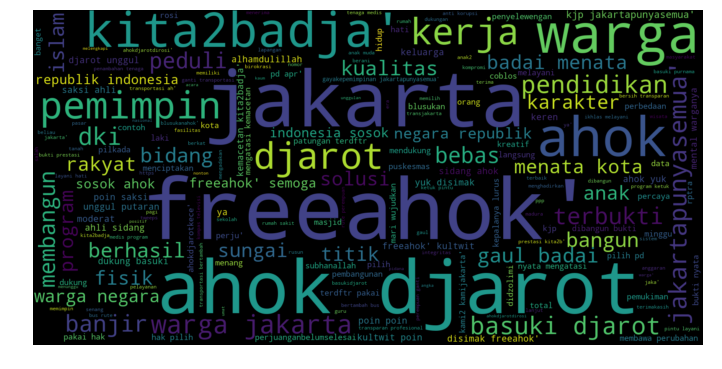

In [218]:
pos_tweets = clean_df[clean_df["target"] == "positif"]
pos_string = []
for t in pos_tweets["isi"]:
    pos_string.append(t)
pos_string = pd.Series(str(pos_string)).str.cat(sep=' ')

from wordcloud import WordCloud

wc_pos = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.show()

### Negative Tweet

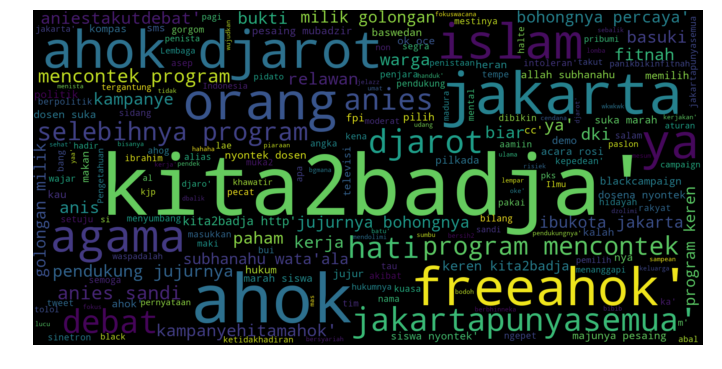

In [219]:
neg_tweets = clean_df[clean_df["target"] == "negatif"]
neg_string = []
for t in neg_tweets["isi"]:
    neg_string.append(t)
neg_string = pd.Series(str(neg_string)).str.cat(sep=' ')

wc_neg = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.show()

### Netral Tweet

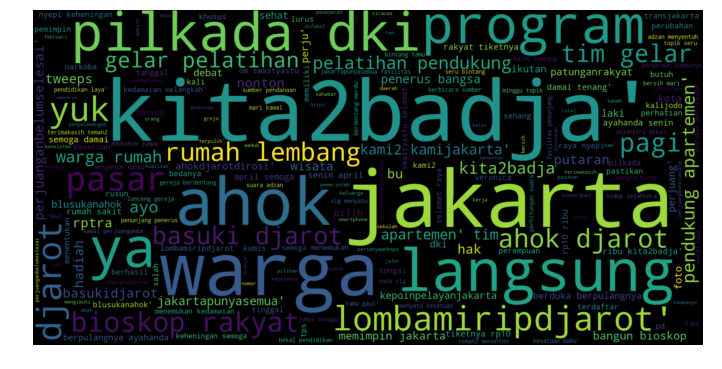

In [220]:
net_tweets = clean_df[clean_df["target"] == "netral"]
net_string = []
for t in net_tweets.isi:
    net_string.append(t)
net_string = pd.Series(str(net_string)).str.cat(sep=' ')

wc_net = WordCloud(width=1600, height=800,max_font_size=200).generate(net_string)
plt.figure(figsize=(12,10))
plt.imshow(wc_net, interpolation="bilinear")
plt.axis("off")
plt.show()

## Sentiment Classification

In [0]:
X = clean_df["isi"]
y = clean_df["target"]

### 1. Feature Enginering

##### - Bag of Words

In [222]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_counts = count_vect.fit_transform(X)
print(X_counts.shape)

(650, 1645)


#### - TF-IDF

In [271]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
X_tfidf.shape

(650, 1645)

### 2. Cross Validation

In [225]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
classifiers = [MultinomialNB(), RidgeClassifier(), PassiveAggressiveClassifier()]
accuracy = {}
for classifier in classifiers:
  cv_result =cross_val_score(classifier, X_tfidf, y, cv=10)
  accuracy[str(classifier).split("(")[0]] = cv_result.mean()
print("Dengan menggunakan 10-Fold Cross-Validation diperoleh akurasi untuk masing-masing metode sebagai berikut:")
for classifier in accuracy:
  print(classifier, ":", accuracy[classifier])

Dengan menggunakan 10-Fold Cross-Validation diperoleh akurasi untuk masing-masing metode sebagai berikut:
MultinomialNB : 0.541611653272101
RidgeClassifier : 0.5781870694603903
PassiveAggressiveClassifier : 0.5749483352468427


Dari hasil di atas dapat dilihat bahwa model RidgeClassifier memiliki akurasi yang paling tinggi yakni sebesar 0,58 sehingga model inilah yang akan digunakan untuk analisis sentimen twitter.

### 3. Pemodelan dengan RidgeClassifier dan Prediksi







In [0]:
model = RidgeClassifier().fit(X_tfidf, y)

In [278]:
def prediksi_ridge(list_tweet):
  clean_twt = []
  for tweet in list_tweet:
    clean_twt.append(tweet_cleaner(tweet))
  # bag of words
  X_new_counts = count_vect.transform(clean_twt)
  # tf-idf
  X_new_tfidf = tfidf_transformer.transform(X_new_counts)
  pred = model.predict(X_new_tfidf)
  return pred[0]

contoh_tweet = ["Siapa pun yg menang dukung"]
prediksi_ridge(contoh_tweet)

'positif'